## Evaluation Heatmap
As in Nettekoven 2024, we are using average group models and evaluating them now on a wider set of evaluation datasets. 

* Use Condition Half and cross evaluation
* Baseline subtraction after adding rest (if necessary)
* New extracted data after change of Functional Fusion 
* Even evaluated on same dataset, use L-O-O evaluation
* Use average cortical activity  


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

### Loading avg and loo models

In [3]:
method = 'L2reghalf'
train_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]#, "Fusion"]
eval_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
eval_names = ["MDTB", "Languagelocalizer", "Socialsocial", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
df_all = pd.DataFrame()
for i, dataset_name in enumerate(train_ds_list):

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-Cavg"],methods=[method],eval_data=eval_names,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-Cavg"],methods=[method],eval_data=[eval_names[i]],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

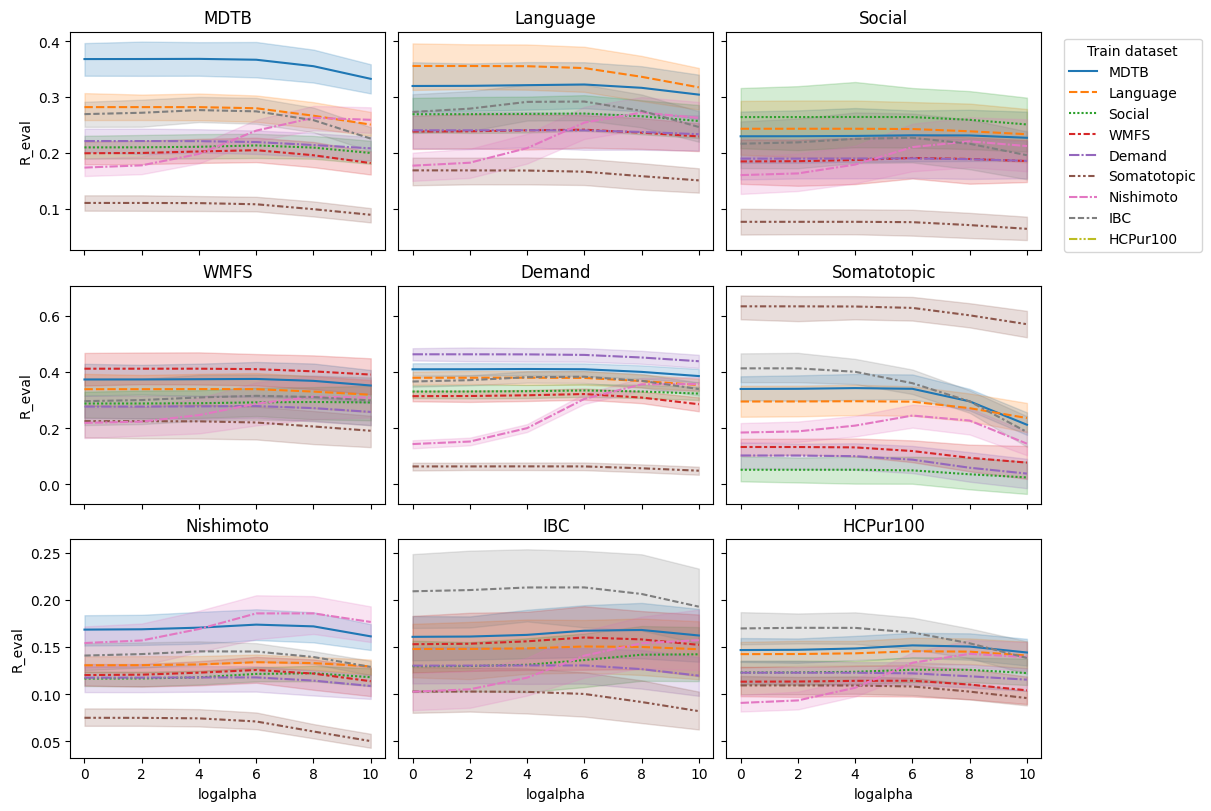

In [4]:
fig, axes = plt.subplots(np.ceil(len(eval_ds_list) / 3).astype(int), 3, figsize=(12, 8), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax = axes[i // 3, i % 3]
    df_to_plot = df_all[(df_all.eval_dataset==ed) & ((df_all.train_dataset!=ed)
                                                     | (df_all.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, ax=ax)
    ax.set_title(ed)

    if i == 2:
        ax.legend(title='Train dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove()

# Remove extra subplots if more than len(eval_ds_list)
if len(eval_ds_list) < axes.size:
    for j in range(len(eval_ds_list), axes.size):
        fig.delaxes(axes.flatten()[j])

### Find best hyperparameter

In [5]:
A = pd.pivot_table(df_all, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                  
logalpha           0.0       2.0       4.0       6.0       8.0       10.0
train_dataset                                                            
MDTB           0.278929  0.279142  0.280199  0.281303  0.274709  0.260246
Language       0.259189  0.259250  0.259583  0.259500  0.251978  0.241265
Social         0.214363  0.214483  0.215232  0.217274  0.214933  0.209004
WMFS           0.210835  0.211165  0.212765  0.214133  0.206913  0.195668
Demand         0.231562  0.231556  0.231476  0.230322  0.224483  0.216935
Somatotopic    0.132596  0.132575  0.132406  0.130803  0.122537  0.112885
Nishimoto      0.144566  0.149105  0.172442  0.219154  0.239484  0.232705
IBC            0.257322  0.259989  0.264916  0.262749  0.248601  0.223112

,best_logalpha
train_dataset,
MDTB,6.0
Language,4.0
Social,6.0
WMFS,6.0
Demand,0.0
Somatotopic,0.0
Nishimoto,8.0
IBC,4.0


### Evaluation Heatmap at best Hyperparameter

Text(45.72222222222221, 0.5, 'Eval Dataset')

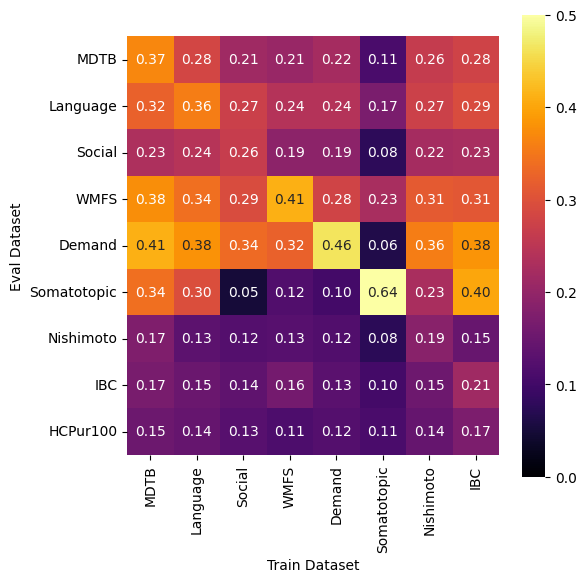

In [6]:
plt.figure(figsize=(6,6))

df_to_plot = df_all[df_all.isbest].reset_index(drop=True)
V = pd.pivot_table(df_to_plot, columns='train_dataset', index='eval_dataset', values='R_eval')
V = V.reindex(eval_ds_list, axis=0)
V = V.reindex(train_ds_list, axis=1)

sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.5, 
            xticklabels=V.columns.values, 
            yticklabels=V.index.values, square=True)
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset')